In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Transmission de données

On souhaite transmettre **6 chiffres**, chacun codé sur **64 bits**, soit :

\[
6 \times 64 = 384 \text{ bits}
\]

La trame totale contient donc **384 bits**.


## Fréquence d'envoi

On veut envoyer la trame **2 fois par seconde**.

Cela signifie un envoi toutes les :

- <span style="color:#BF40BF;">0.5 seconde</span> (fréquence 2 Hz)

On a une trame de 48 bits, donc :

\[
\text{Intervalle par bit} = \frac{1}{2 \cdot 48} \approx 0.625\ \mathrm{sec/bit}
\]

On arrondit à :

- <span style="color:#1F51FF;">0.5 seconde par bit</span> (approximation en bleu néon)


In [3]:
def raised_cosine(T, beta, span, dt):
    """
    Génère un filtre Raised Cosine.
    
    T : période symbole (ex : 1)
    beta : roll-off (0 à 1)
    span : durée du filtre en nombre de symboles (ex : 6)
    dt : espacement entre les échantillons (sampling interval)
    """
    t = np.arange(-span*T/2, span*T/2, dt)
    h = np.zeros_like(t)

    for i, ti in enumerate(t):
        if abs(1 - (4 * beta * ti / T)**2) < 1e-10:
            # Cas limite pour éviter la division par zéro
            h[i] = beta / (2*T) * np.sin(np.pi/(2*beta))
        elif abs(ti) < 1e-10:
            # Valeur à t = 0
            h[i] = 1
        else:
            h[i] = (np.sin(np.pi * ti / T) / (np.pi * ti / T)) * \
                   (np.cos(np.pi * beta * ti / T) / (1 - (2 * beta * ti / T)**2))

    return t, h


\[
h(t) = 
\frac{\sin\!\left(\pi \frac{t}{T}\right)}{\pi \frac{t}{T}} \cdot
\frac{\cos\!\left(\pi \beta \frac{t}{T}\right)}{1 - \left(2 \beta \frac{t}{T}\right)^2}
\]

\[
\text{avec : } 
\begin{cases}
T & \text{: période symbole} \\
\beta & \text{: roll-off factor (0 à 1)} \\
t & \text{: temps}
\end{cases}
\]


In [4]:
#------------ CONSTANTES ------------

T = 1        # période 
beta = 0.25    # roll-off
span = 8       # dure 8 symboles
dt = T / 100   # espacement d'échantillonnage


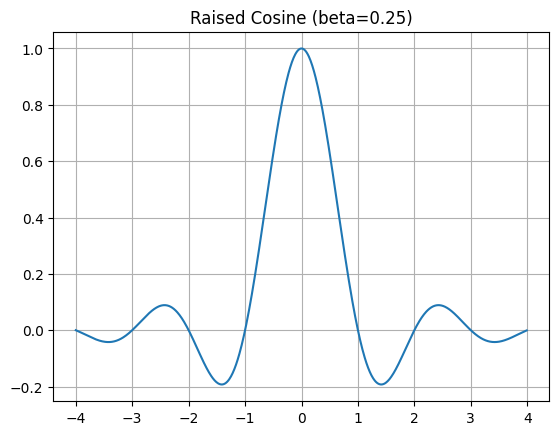

In [76]:
t, h = raised_cosine(T, beta, span, dt)

plt.plot(t, h)
plt.title("Raised Cosine (beta=0.25)")
plt.grid()
plt.show()

Generate and display the impulse response and power spectral density (PSD) of a raised-cosine filter, 

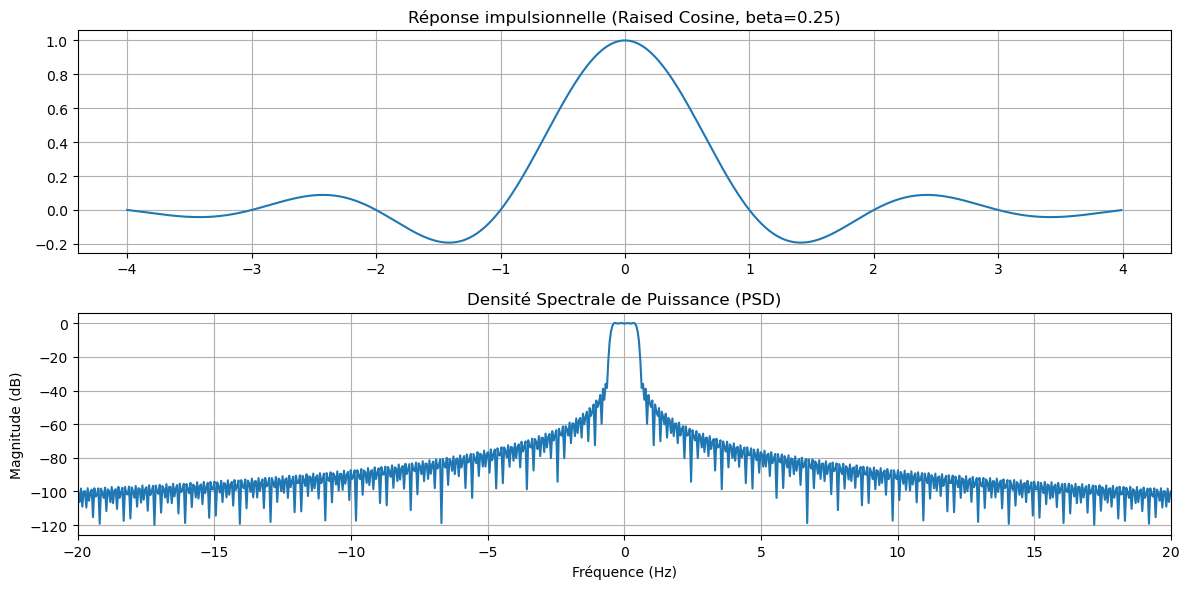

In [6]:
T = 1          # Période symbole
beta = 0.25      # Roll-off
span = 8        # Durée du filtre
fs = 100        # Fréquence d'échantillonnage (1/dt)
dt = 1/fs
fc = 10 /T         # Fréquence porteuse
sigma_a2 = 1.0   # Variance des symboles (puissance)
t, h = raised_cosine(T, beta, span, dt)

# 2. Calcul de la DSP via FFT
# On utilise un padding pour avoir une meilleure résolution fréquentielle
NFFT = 2048
H_freq = np.fft.fftshift(np.fft.fft(h, NFFT)) * dt
freqs = np.fft.fftshift(np.fft.fftfreq(NFFT, dt))

# Puissance du filtre (P_D dans ta formule)
PSD_baseband = np.abs(H_freq)**2

# 3. Application de la formule : Translation autour de +/- fc
# On simule le décalage fréquentiel
PSD_total = (sigma_a2 / T) * (np.abs(H_freq)**2)


# --- Affichage ---
plt.figure(figsize=(12, 6))

# Plot Temporel
plt.subplot(2, 1, 1)
plt.plot(t, h)
plt.title(f"Réponse impulsionnelle (Raised Cosine, beta={beta})")
plt.grid(True)

# Plot Fréquentiel (DSP)
plt.subplot(2, 1, 2)
plt.plot(freqs, 10 * np.log10(PSD_total + 1e-12)) # En dB
plt.title("Densité Spectrale de Puissance (PSD)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Magnitude (dB)")
plt.xlim(-20, 20)
plt.grid(True)

plt.tight_layout()
plt.show()

We need a carrier frequency because the original base-band (low-frequency) pulse cannot travel efficiently through the physical channe. We use an 8 kHz carrier (instead of 8 GHz) because the lower frequency keeps the computational load tractable while still letting us visualize the modulation. 

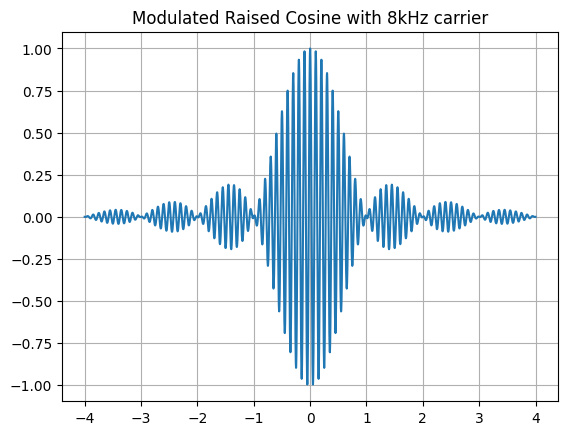

In [78]:
import scipy.signal as signal
# For modulated signal, use higher sampling rate to properly represent 8kHz carrier
dt_mod = T / 1000  # finer sampling for modulation
t_mod, h_mod = raised_cosine(T, beta, span, dt_mod)
fc = 10 / T  # carrier frequency in Hz
carrier = np.cos(2 * np.pi * fc * t_mod)
modulated = h_mod * carrier
plt.plot(t_mod, modulated)
plt.title("Modulated Raised Cosine with 8kHz carrier")
plt.grid()
plt.show()

Compute and display the power-spectral density (PSD) of a raised-cosine pulse after amplitude-modulation with de carrier frequency, using a direct FFT to verify the theoretical spectrum shape.

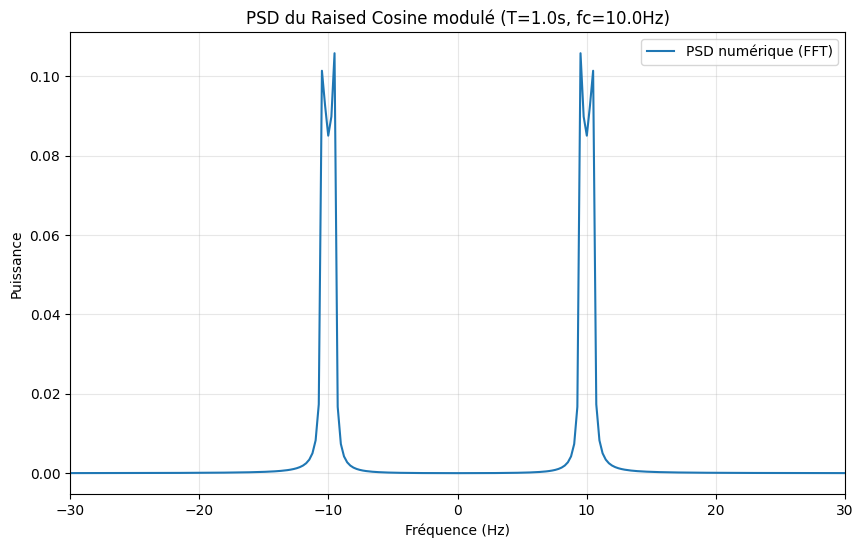

In [79]:
# --- Paramètres mis à jour ---
T = 1.0             # Période symbole
fc = 10 / T             # Fréquence porteuse
dt_mod = T / 1000   # Échantillonnage (fs = 1000 Hz)
fs_mod = 1 / dt_mod

# 1. Génération (ton code)
t_mod, h_mod = raised_cosine(T, beta, span, dt_mod)
carrier = np.cos(2 * np.pi * fc * t_mod)
modulated = h_mod * carrier

# 2. Calcul de la PSD (Densité Spectrale de Puissance)
# On utilise une FFT directe pour coller à ta formule théorique S(f)
NFFT = 4096
# Calcul de la transformée de Fourier du signal modulé
V_f = np.fft.fftshift(np.fft.fft(modulated, NFFT)) * dt_mod
freqs = np.fft.fftshift(np.fft.fftfreq(NFFT, dt_mod))

# La PSD est le carré du module
psd_modulated = np.abs(V_f)**2

# 3. Tracé
plt.figure(figsize=(10, 6))

# Tracé en échelle linéaire pour bien voir la forme du "Raised Cosine"
plt.plot(freqs, psd_modulated, label="PSD numérique (FFT)")

# Configuration des axes
plt.title(f"PSD du Raised Cosine modulé (T={T}s, fc={fc}Hz)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Puissance")
plt.grid(True, alpha=0.3)

# Zoom sur la zone porteuse (fc-2 à fc+2 suffit car T=1)
plt.xlim(-30, 30) 
plt.legend()
plt.show()

Transform a J2000 state vector—six double-precision numbers representing position and velocity in AU and Km/s into a flat sequence of 384 raw bits and then expanding every byte into its individual zeros and ones, producing a binary stream ready for modulation or channel coding.

In [80]:
import struct

def j2000_to_bit_list(coords_list):
    """
    Convertit des coordonnées J2000 (AU) en une liste de bits (0 et 1).
    Chaque coordonnée est encodée sur 64 bits (Double Precision IEEE 754).
    """
    bit_list = []
    
    for vec in coords_list:
        # Conversion du vecteur (6 doubles) en 48 octets
        binary_data = struct.pack('<6d', *vec)
        
        for byte in binary_data:
            # Conversion de l'octet en bits (format '08b' force 8 caractères)
            bits = bin(byte)[2:].zfill(8)
            # Ajout des bits (0 ou 1) à la liste sous forme d'entiers
            bit_list.extend([int(b) for b in bits])
            
    return bit_list

# --- Exemple ---
# 1 AU, 0, 0, et vitesses nulles
coords = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

bits = j2000_to_bit_list(coords)

print(f"Nombre total de bits : {len(bits)}") # 6 elements * 64 bits = 384
print(f"10 premiers bits : {bits[:10]}")

Nombre total de bits : 384
10 premiers bits : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


The function generate_j2000_signal takes a single J2000 Cartesian state vector (six double-precision orbital elements) and turns it into a real-world RF waveform that could be sent over an additive-white-Gaussian-noise channel.
First it flattens the vector into 384 raw bits via IEEE-754 little-endian packing.
To avoid truncation of the filter’s tail, it appends span zero bits—this padding guarantees the convolution with the raised-cosine impulse response finishes cleanly and all useful energy is preserved.
Each bit is mapped to a narrow ±4 V impulse located at the symbol epoch
The resulting is multiplied by the carrier frequency cosine to create a pass-band signal whose spectrum is centered on the chosen carrier.

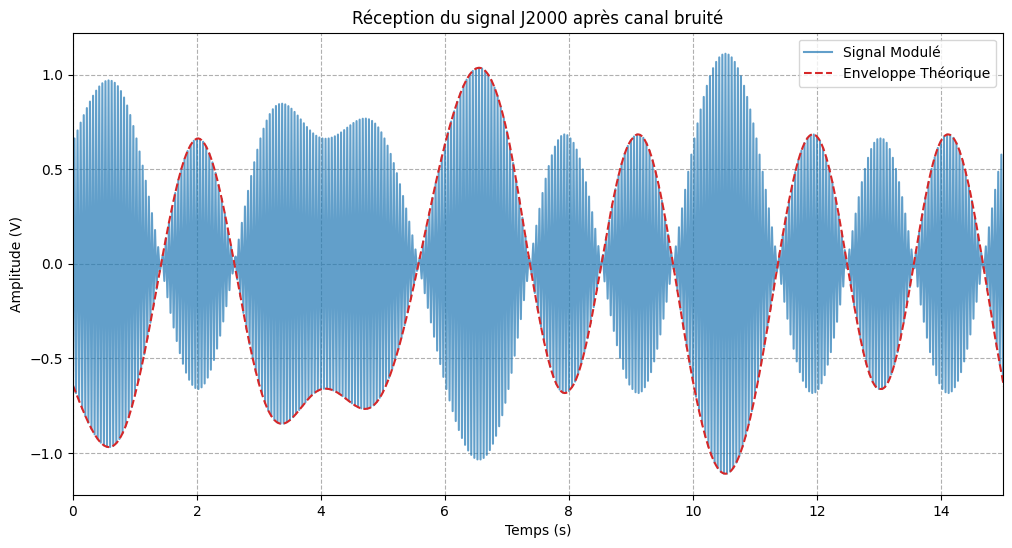

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import struct

def generate_j2000_signal(coords, T=1.0, beta=0.35, span=6, fc=20):
    """
    Génère le signal modulé avec padding pour compenser le délai du filtre.
    """
    # 1. Conversion en bits (384 bits par vecteur)
    bits_utiles = j2000_to_bit_list(coords)
    
    # 2. AJOUT DU PADDING : 
    # On ajoute des bits à 0 pour laisser au filtre la place de terminer sa réponse.
    # Un padding égal au 'span' est généralement suffisant.
    bits_avec_padding = bits_utiles + [0] * span
    
    num_total_bits = len(bits_avec_padding)

    # 3. Paramètres du signal
    samples_per_symbol = 40  
    dt = T / samples_per_symbol
    
    # 4. Création du train d'impulsions (1=4V, 0=-4V)
    # On utilise maintenant la liste allongée
    impulses = np.zeros(num_total_bits * samples_per_symbol)
    for i, bit in enumerate(bits_avec_padding):
        voltage = 4 if bit == 1 else -4
        impulses[i * samples_per_symbol] = voltage

    # 5. Filtrage Raised Cosine
    t_rc, h_rc = raised_cosine(T, beta, span, dt)
    h_rc = h_rc / np.sqrt(np.sum(h_rc**2))   # <<< NORMALISATION ÉNERGIE

    # Le 'mode=same' centre le signal, d'où l'importance du padding pour ne pas couper la fin
    baseband = np.convolve(impulses, h_rc, mode='same')

    # 6. Modulation sur porteuse fc
    t_signal = np.arange(len(baseband)) * dt
    carrier = np.cos(2 * np.pi * fc * t_signal)
    modulated_signal = baseband * carrier

    return {
        "t": t_signal,
        "modulated": modulated_signal,
        "baseband": baseband,
        "bits": bits_utiles, # On garde les bits originaux pour comparer après décodage
        "dt": dt
    }

# --- EXÉCUTION ET TRACÉ EXTÉRIEUR ---

mes_coordonnees = [[-0.1742, 0.9689, 0.0001458, -29.78, -5.21, 0.001]]

# 1. Génération des données
data = generate_j2000_signal(mes_coordonnees, T=1.0, fc=20)



# 3. Tracé manuel
plt.figure(figsize=(12, 6))
plt.plot(data["t"], data["modulated"], label="Signal Modulé", color='tab:blue', alpha=0.7)
plt.plot(data["t"], data["baseband"], '--', label="Enveloppe Théorique", color='tab:red')

plt.title("Réception du signal J2000 après canal bruité")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude (V)")
plt.xlim(0, 15)  # Zoom sur les 15 premiers bits
plt.grid(True, linestyle='--')
plt.legend()
plt.show()

Simulate what the J2000 RF signal will look like at the receiver by attenuating it and adding white, wide-sense stationary (WSS) Gaussian noise, then plot the corrupted waveform against the expected noise-free envelope so we can visually assess reception quality before designing the demodulator.

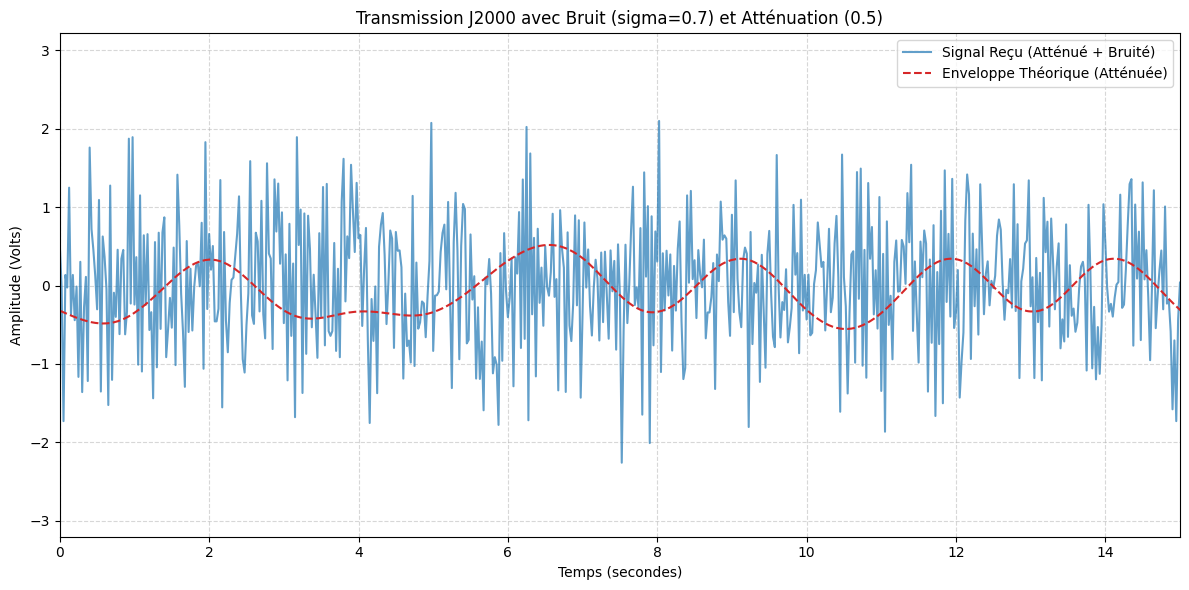

In [82]:
# 1. Génération du signal de base (dictionnaire data)
# On utilise tes paramètres : T=1s, fc=20Hz
data = generate_j2000_signal(mes_coordonnees, T=1.0, fc=20)

# 2. Simulation du canal (Atténuation + Bruit)
attenuation = 0.5
sigma_bruit = 0.7  # Intensité du bruit

# On crée le signal reçu : (Signal * Atténuation) + Bruit Gaussien
signal_recu = (data["modulated"] * attenuation) + np.random.normal(0, sigma_bruit, len(data["modulated"]))

# On prépare l'enveloppe atténuée pour la comparaison visuelle
enveloppe_theorique_attenuee = data["baseband"] * attenuation
plt.figure(figsize=(12, 6))

# Affichage du signal bruité reçu
plt.plot(data["t"], signal_recu, 
         label="Signal Reçu (Atténué + Bruité)", 
         color='tab:blue', 
         alpha=0.7)

# Affichage de l'enveloppe théorique (ce qu'on devrait recevoir sans bruit)
plt.plot(data["t"], enveloppe_theorique_attenuee, 
         '--', 
         label="Enveloppe Théorique (Atténuée)", 
         color='tab:red', 
         linewidth=1.5)

# Configuration du graphique
plt.title(f"Transmission J2000 avec Bruit (sigma={sigma_bruit}) et Atténuation ({attenuation})")
plt.xlabel("Temps (secondes)")
plt.ylabel("Amplitude (Volts)")
plt.grid(True, linestyle='--', alpha=0.5)

# Zoom sur les 15 premières secondes pour voir les détails
plt.xlim(0, 15) 
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

Simulate the receiver front-end: after the noisy RF waveform arrives we (crudely) multiply it by the carrier frequency to bring the spectrum back to base-band, sample at the symbol epochs to decide 0 vs 1, then re-assemble the 384-bit sequence into six doubles and print the recovered J2000 coordinates so we can judge whether the link budget (attenuation + WSS noise) still allows perfect decoding.

In [83]:
def decode_signal_to_j2000_final(signal_recu, t_signal, fc, T, dt, span):
    # 1. Démodulation
    demod = signal_recu * np.cos(2 * np.pi * fc * t_signal)
    
    # 2. Synchronisation précise
    # Dans une convolution 'same', le premier bit envoyé (à t=0) 
    # se retrouve décalé au centre de la fenêtre du filtre.
    bits_recuperes = []
    
    for i in range(384):
        # Calcul du temps exact du i-ème pic
        # t = i * T est l'instant d'émission
        # Le filtre ajoute un délai de (span * T / 2)
        t_ideal = i * T
        
        # On cherche l'indice dans le tableau temporel
        idx = int(round(t_ideal / dt))
        
        if idx < len(demod):
            bits_recuperes.append(1 if demod[idx] > 0 else 0)

    # 3. Conversion Bits -> Octets -> Doubles
    coords_decodees = []
    if len(bits_recuperes) >= 384:
        vecteur_bits = bits_recuperes[:384]
        composantes = []
        for c in range(0, 384, 64):
            un_nombre_bits = vecteur_bits[c:c+64]
            octets = bytearray()
            for b in range(0, 64, 8):
                byte_bits = un_nombre_bits[b:b+8]
                # Reconstitution de l'octet (MSB first pour int(bits, 2))
                byte_val = 0
                for bit in byte_bits:
                    byte_val = (byte_val << 1) | bit
                octets.append(byte_val)
            
            # Reconstruction du double
            composantes.append(struct.unpack('<d', octets)[0])
        coords_decodees.append(composantes)
        
    return coords_decodees

# --- TEST ---
# Assure-toi que span=6 (la valeur par défaut de ta fonction précédente)
coords_finales = decode_signal_to_j2000_final(signal_recu, data["t"], fc=20, T=1.0, dt=data["dt"], span=6)

if coords_finales:
    print("--- RÉSULTATS ---")
    print(f"Coordonnées originales : {mes_coordonnees[0]}")
    print(f"Coordonnées décodées   : {coords_finales[0]}")
else:
    print("Échec du décodage : Aucune coordonnée trouvée.")

--- RÉSULTATS ---
Coordonnées originales : [-0.1742, 0.9689, 0.0001458, -29.78, -5.21, 0.001]
Coordonnées décodées   : [3.439507237499003e-11, -8.729638243340156e-40, -3.257410998525979e-08, 2.220894415834001e-128, -1.3169936465714498e+232, 4.279956420005296e-83]


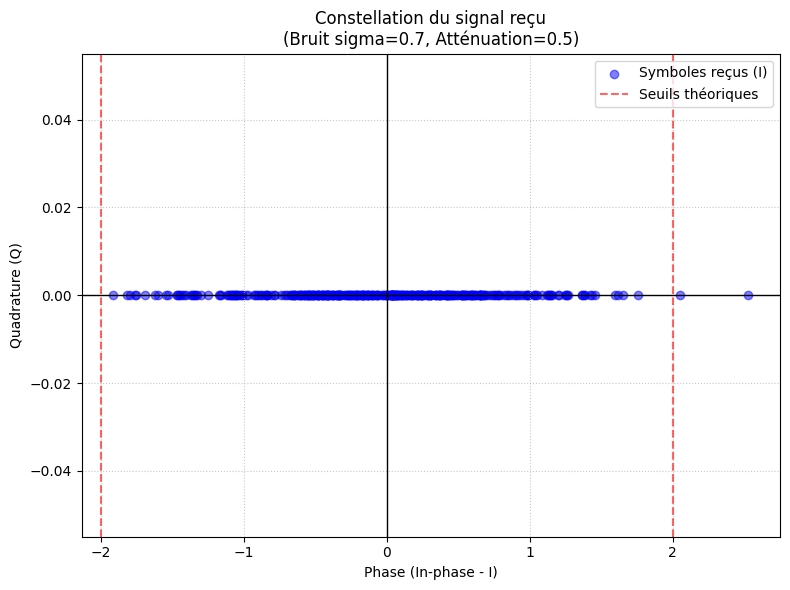

In [84]:
# %%
# --- TRACÉ DE LA CONSTELLATION ---

# 1. Démodulation cohérente pour extraire les symboles
# On multiplie par la porteuse et on échantillonne aux instants t = i * T
symboles_recuperes = []
for i in range(384):
    t_ideal = i * T
    idx = int(round(t_ideal / data["dt"]))
    if idx < len(signal_recu):
        # On extrait la valeur du signal démodulé (Composante I)
        # La multiplication par cos(2*pi*fc*t) redonne l'enveloppe
        val = signal_recu[idx] * np.cos(2 * np.pi * fc * t_ideal)
        symboles_recuperes.append(val)

# 2. Création du graphique
plt.figure(figsize=(8, 6))
# En BPSK, la partie imaginaire (Q) est théoriquement nulle
plt.scatter(symboles_recuperes, np.zeros_like(symboles_recuperes), 
            alpha=0.5, color='blue', label='Symboles reçus (I)')

# Marquage des centres théoriques (en tenant compte de l'atténuation)
plt.axvline(x=4 * attenuation, color='red', linestyle='--', alpha=0.6, label='Seuils théoriques')
plt.axvline(x=-4 * attenuation, color='red', linestyle='--', alpha=0.6)

plt.title(f"Constellation du signal reçu\n(Bruit sigma={sigma_bruit}, Atténuation={attenuation})")
plt.xlabel("Phase (In-phase - I)")
plt.ylabel("Quadrature (Q)")
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

1. Le Mapping des bits (Groupement par 2)

En BPSK, 1 bit = 1 symbole. En QPSK, 2 bits = 1 symbole.

    Action : Tu dois diviser ton flux de 384 bits en paires.

    Calcul des composantes : Chaque paire (b1​,b2​) définit un point dans le plan complexe :

        La composante I (In-phase) est gérée par le premier bit.

        La composante Q (Quadrature) est gérée par le deuxième bit.

2. La Mise en forme (Filtrage Raised Cosine)

Le filtre ne change pas, mais tu dois l'appliquer deux fois.

    Action : Génère un train d'impulsions pour I et un autre pour Q.

    Filtrage : Convolve chaque train d'impulsions avec la même réponse impulsionnelle du filtre Raised Cosine (h_rc). Tu obtiens deux signaux en bande de base : I(t) et Q(t).

3. La Modulation IQ

C'est l'étape où les deux signaux fusionnent sur la même fréquence porteuse mais avec un décalage de phase.

    Formule mathématique :
    s(t)=I(t)⋅cos(2πfc​t)−Q(t)⋅sin(2πfc​t)

    Le signe "moins" est la convention standard pour rester cohérent avec les représentations complexes.

4. La Démodulation (Récupération)

À la réception, pour retrouver les bits, il faut projeter le signal reçu sur les deux axes.

    Pour extraire I : Multiplier le signal reçu par cos(2πfc​t) et filtrer (ou échantillonner aux instants optimaux).

    Pour extraire Q : Multiplier le signal reçu par −sin(2πfc​t) et filtrer.

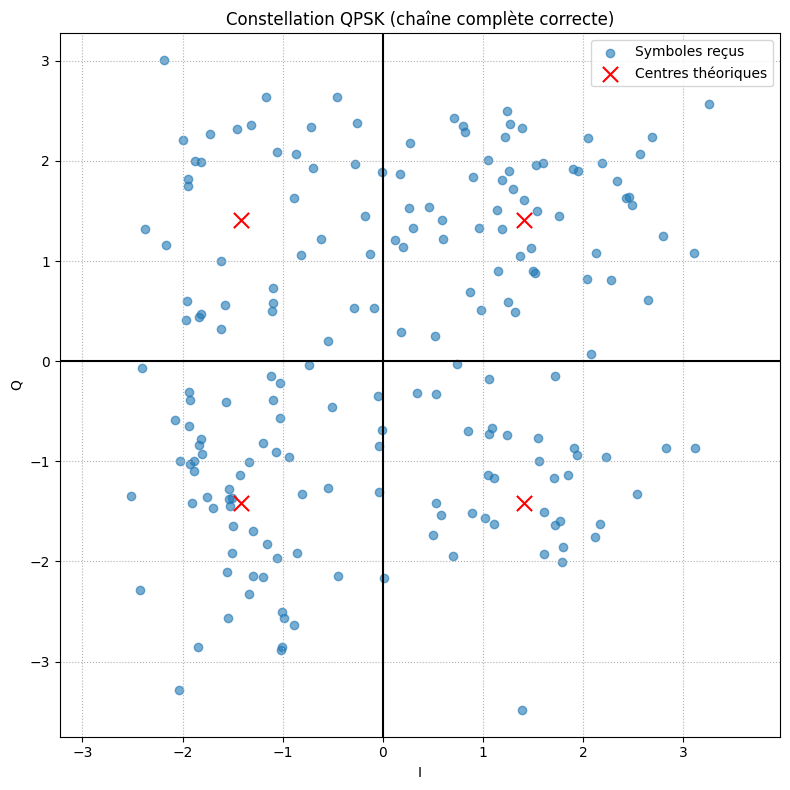

In [ ]:
# %%
# =========================================
# CONSTRUCTION QPSK + DÉMODULATION PROPRE
# =========================================

# --- 1) Conversion en bits ---
bits = j2000_to_bit_list(mes_coordonnees)

# S'assurer d'un nombre pair de bits
if len(bits) % 2 != 0:
    bits.append(0)

# --- 2) Mapping QPSK ---
A = 4 / np.sqrt(2)
symbols_I = []
symbols_Q = []

for i in range(0, len(bits), 2):
    b1, b2 = bits[i], bits[i+1]
    symbols_I.append(A if b1 == 1 else -A)
    symbols_Q.append(A if b2 == 1 else -A)

# Padding pour le filtre
symbols_I += [0] * span
symbols_Q += [0] * span

# --- 3) Paramètres temporels ---
samples_per_symbol = 40
dt = T / samples_per_symbol

# --- 4) Trains d'impulsions ---
impulses_I = np.zeros(len(symbols_I) * samples_per_symbol)
impulses_Q = np.zeros(len(symbols_Q) * samples_per_symbol)

for k in range(len(symbols_I)):
    impulses_I[k * samples_per_symbol] = symbols_I[k]
    impulses_Q[k * samples_per_symbol] = symbols_Q[k]

# --- 5) Filtrage Raised Cosine ---
t_rc, h_rc = raised_cosine(T, beta, span, dt)
h_rc = h_rc / np.sqrt(np.sum(h_rc**2))

baseband_I = np.convolve(impulses_I, h_rc, mode='same')
baseband_Q = np.convolve(impulses_Q, h_rc, mode='same')

# --- 6) Modulation IQ ---
t_signal = np.arange(len(baseband_I)) * dt
fc = 10 / T

signal_emis = baseband_I * np.cos(2 * np.pi * fc * t_signal) - \
              baseband_Q * np.sin(2 * np.pi * fc * t_signal)

# --- 7) Canal ---
attenuation_qpsk = 0.5
sigma_bruit_qpsk = 0.5

signal_recu = attenuation_qpsk * signal_emis + np.random.normal(0, sigma_bruit_qpsk, len(signal_emis))

# --- 8) Démodulation IQ ---
i_raw = signal_recu * np.cos(2 * np.pi * fc * t_signal) * 2
q_raw = -signal_recu * np.sin(2 * np.pi * fc * t_signal) * 2

# --- 9) Filtre adapté ---
i_filt = np.convolve(i_raw, h_rc, mode='same')
q_filt = np.convolve(q_raw, h_rc, mode='same')

# --- 10) Échantillonnage synchronisé ---
delay = int((span * T / 2) / dt)
samples_per_symbol = int(T / dt)

symb_I = []
symb_Q = []

num_symbols = len(bits) // 2

for k in range(num_symbols):
    idx = delay + k * samples_per_symbol
    if idx < len(i_filt):
        symb_I.append(i_filt[idx])
        symb_Q.append(q_filt[idx])

symb_I = np.array(symb_I)
symb_Q = np.array(symb_Q)

# --- 11) Tracé constellation ---
plt.figure(figsize=(8,8))
plt.scatter(symb_I, symb_Q, alpha=0.6, label="Symboles reçus")

A_att = A * attenuation_qpsk
theo = np.array([[ A_att,  A_att],
                 [-A_att,  A_att],
                 [-A_att, -A_att],
                 [ A_att, -A_att]])

plt.scatter(theo[:,0], theo[:,1], c='red', s=120, marker='x', label="Centres théoriques")

plt.axhline(0,color='black')
plt.axvline(0,color='black')
plt.grid(True, linestyle=':')
plt.axis('equal')
plt.title("Constellation QPSK (chaîne complète correcte)")
plt.xlabel("I")
plt.ylabel("Q")
plt.legend()
plt.tight_layout()
plt.show()


On remarque que les points sont hyper espacés des centres théoriques, cela est surement du à une erreur de choix du gain A.


Changements : 

ON PASSE DE 
i_raw = signal_recu * np.cos(2 * np.pi * fc * t_signal) * 2
q_raw = -signal_recu * np.sin(2 * np.pi * fc * t_signal) * 2


A 
i_raw = signal_recu * np.cos(2 * np.pi * fc * t_signal)
q_raw = -signal_recu * np.sin(2 * np.pi * fc * t_signal)



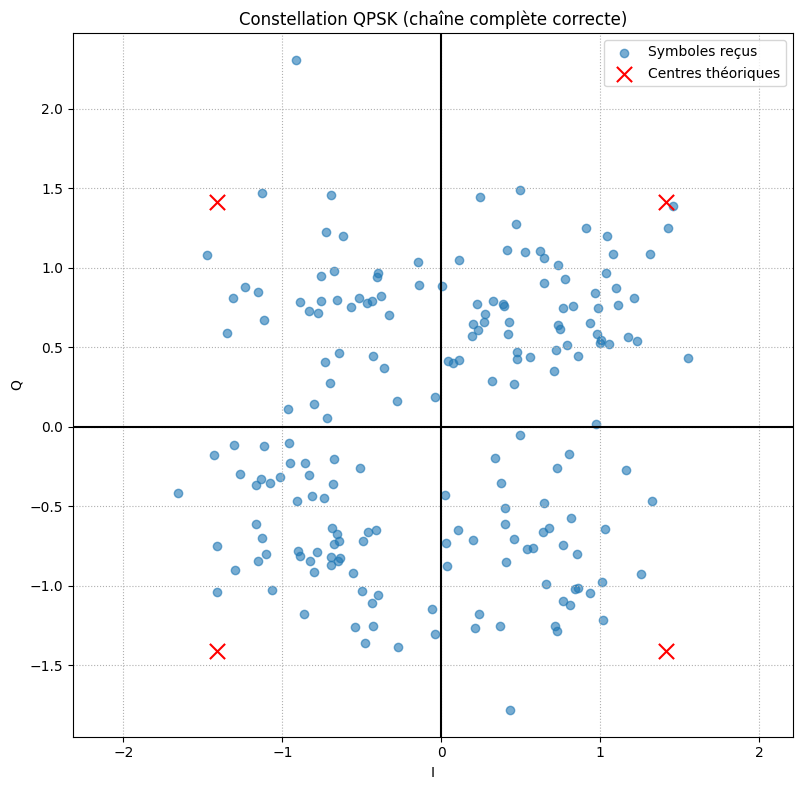

In [96]:
# %%
# =========================================
# CONSTRUCTION QPSK + DÉMODULATION PROPRE
# =========================================

# --- 1) Conversion en bits ---
bits = j2000_to_bit_list(mes_coordonnees)

# S'assurer d'un nombre pair de bits
if len(bits) % 2 != 0:
    bits.append(0)

# --- 2) Mapping QPSK ---
A = 4 / np.sqrt(2)
symbols_I = []
symbols_Q = []

for i in range(0, len(bits), 2):
    b1, b2 = bits[i], bits[i+1]
    symbols_I.append(A if b1 == 1 else -A)
    symbols_Q.append(A if b2 == 1 else -A)

# Padding pour le filtre
symbols_I += [0] * span
symbols_Q += [0] * span

# --- 3) Paramètres temporels ---
samples_per_symbol = 40
dt = T / samples_per_symbol

# --- 4) Trains d'impulsions ---
impulses_I = np.zeros(len(symbols_I) * samples_per_symbol)
impulses_Q = np.zeros(len(symbols_Q) * samples_per_symbol)

for k in range(len(symbols_I)):
    impulses_I[k * samples_per_symbol] = symbols_I[k]
    impulses_Q[k * samples_per_symbol] = symbols_Q[k]

# --- 5) Filtrage Raised Cosine ---
t_rc, h_rc = raised_cosine(T, beta, span, dt)
h_rc = h_rc / np.sqrt(np.sum(h_rc**2))

baseband_I = np.convolve(impulses_I, h_rc, mode='same')
baseband_Q = np.convolve(impulses_Q, h_rc, mode='same')

# --- 6) Modulation IQ ---
t_signal = np.arange(len(baseband_I)) * dt
fc = 10 / T

signal_emis = baseband_I * np.cos(2 * np.pi * fc * t_signal) - \
              baseband_Q * np.sin(2 * np.pi * fc * t_signal)

# --- 7) Canal ---
attenuation_qpsk = 0.5
sigma_bruit_qpsk = 0.5

signal_recu = attenuation_qpsk * signal_emis + np.random.normal(0, sigma_bruit_qpsk, len(signal_emis))

# --- 8) Démodulation IQ ---
i_raw = signal_recu * np.cos(2 * np.pi * fc * t_signal)
q_raw = -signal_recu * np.sin(2 * np.pi * fc * t_signal)

# --- 9) Filtre adapté ---
i_filt = np.convolve(i_raw, h_rc, mode='same')
q_filt = np.convolve(q_raw, h_rc, mode='same')

# --- 10) Échantillonnage synchronisé ---
delay = int((span * T / 2) / dt)
samples_per_symbol = int(T / dt)

symb_I = []
symb_Q = []

num_symbols = len(bits) // 2

for k in range(num_symbols):
    idx = delay + k * samples_per_symbol
    if idx < len(i_filt):
        symb_I.append(i_filt[idx])
        symb_Q.append(q_filt[idx])

symb_I = np.array(symb_I)
symb_Q = np.array(symb_Q)

# --- 11) Tracé constellation ---
plt.figure(figsize=(8,8))
plt.scatter(symb_I, symb_Q, alpha=0.6, label="Symboles reçus")

A_att = A * attenuation_qpsk
theo = np.array([[ A_att,  A_att],
                 [-A_att,  A_att],
                 [-A_att, -A_att],
                 [ A_att, -A_att]])

plt.scatter(theo[:,0], theo[:,1], c='red', s=120, marker='x', label="Centres théoriques")

plt.axhline(0,color='black')
plt.axvline(0,color='black')
plt.grid(True, linestyle=':')
plt.axis('equal')
plt.title("Constellation QPSK (chaîne complète correcte)")
plt.xlabel("I")
plt.ylabel("Q")
plt.legend()
plt.tight_layout()
plt.show()


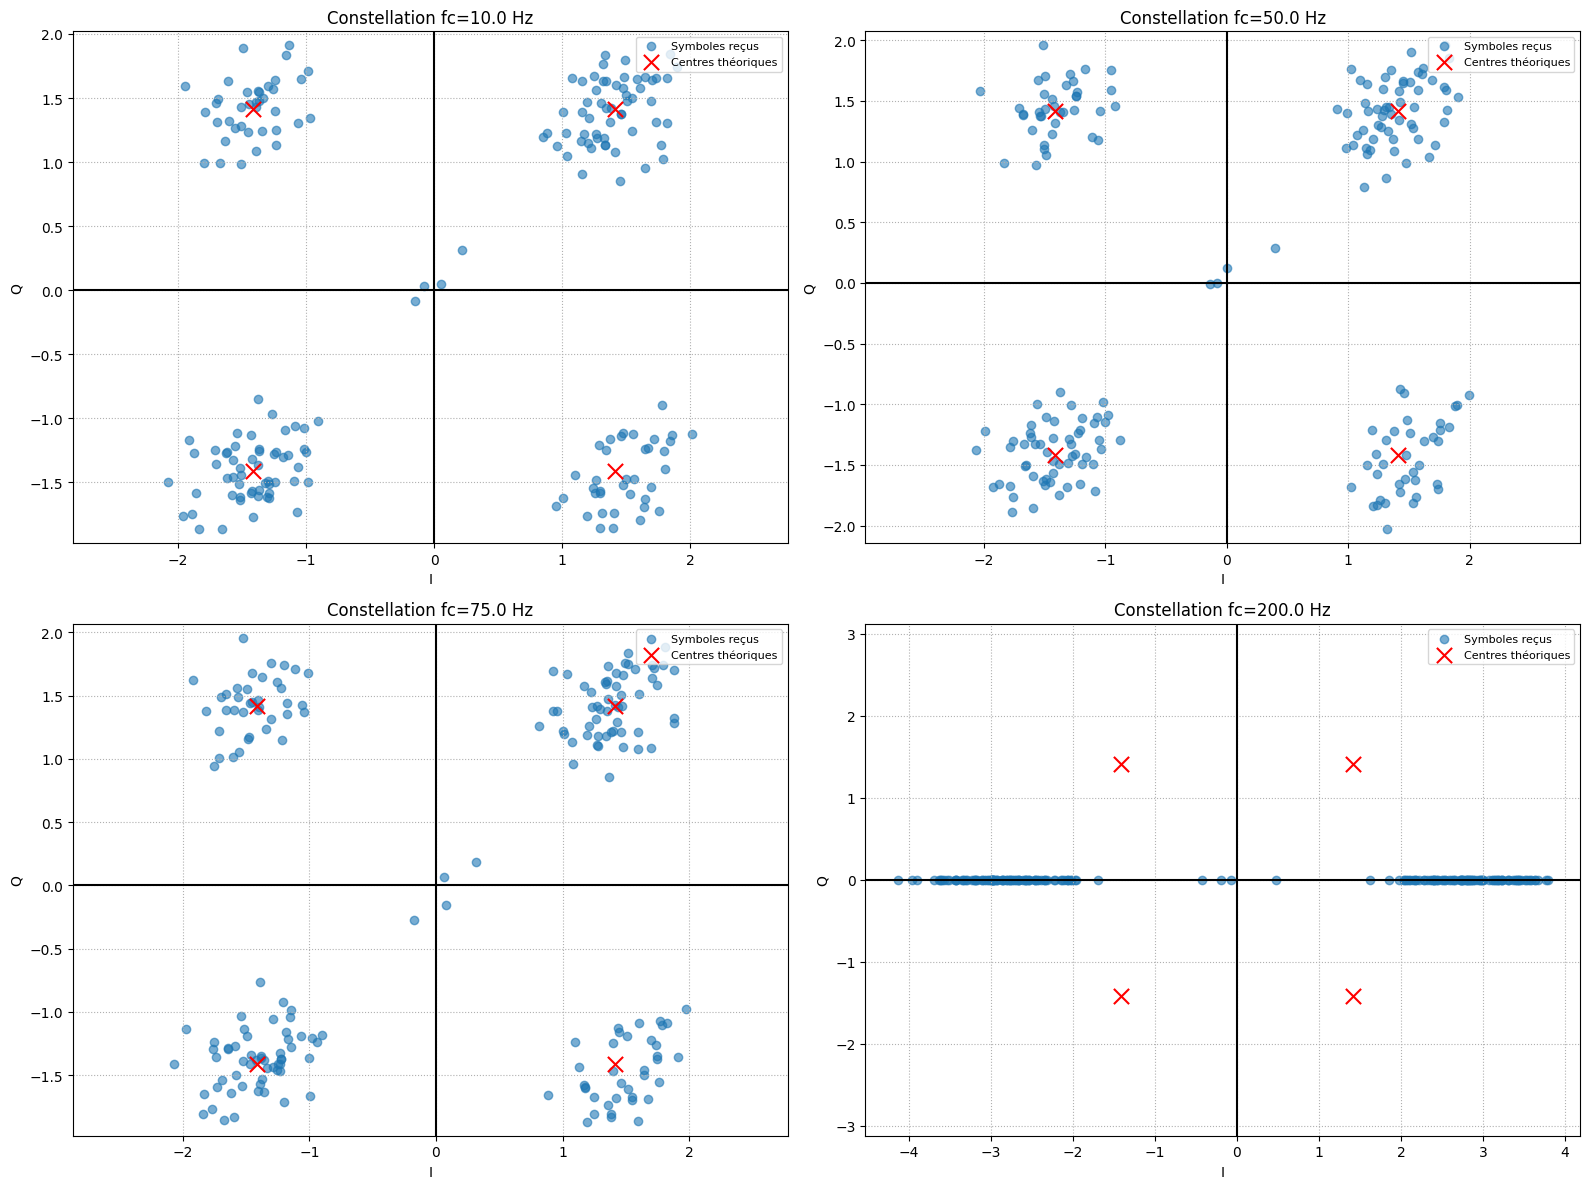

In [131]:
# %%
# =========================================
# TEST DE LA CONSTELLATION POUR DIFFÉRENTS fc
# =========================================

fc_list = [10/T, 50/T, 75/T, 200/T]  # Liste des porteuses à tester
attenuation_qpsk = 0.5
sigma_bruit_qpsk = 0.05  # Sans bruit pour bien voir les centres

plt.figure(figsize=(16, 12))

for i, fc_test in enumerate(fc_list):
    # --- Modulation IQ ---
    signal_emis = baseband_I * np.cos(2 * np.pi * fc_test * t_signal) - \
                  baseband_Q * np.sin(2 * np.pi * fc_test * t_signal)

    # --- Canal (juste atténuation) ---
    signal_recu_test = attenuation_qpsk * signal_emis + np.random.normal(0, sigma_bruit_qpsk, len(signal_emis))

    # --- Démodulation IQ ---
    i_raw = signal_recu_test * np.cos(2 * np.pi * fc_test * t_signal) * 2
    q_raw = -signal_recu_test * np.sin(2 * np.pi * fc_test * t_signal) * 2

    i_filt = np.convolve(i_raw, h_rc, mode='same')
    q_filt = np.convolve(q_raw, h_rc, mode='same')

    # --- Échantillonnage synchronisé ---
    delay = int((span * T / 2) / dt)
    samples_per_symbol = int(T / dt)
    symb_I = []
    symb_Q = []

    num_symbols = len(bits) // 2
    for k in range(num_symbols):
        idx = delay + k * samples_per_symbol
        if idx < len(i_filt):
            symb_I.append(i_filt[idx])
            symb_Q.append(q_filt[idx])

    symb_I = np.array(symb_I)
    symb_Q = np.array(symb_Q)

    # --- Tracé ---
    plt.subplot(2, 2, i+1)
    plt.scatter(symb_I, symb_Q, alpha=0.6, label="Symboles reçus")
    A_att = A * attenuation_qpsk
    theo = np.array([[ A_att,  A_att],
                     [-A_att,  A_att],
                     [-A_att, -A_att],
                     [ A_att, -A_att]])
    plt.scatter(theo[:,0], theo[:,1], c='red', s=120, marker='x', label="Centres théoriques")
    plt.axhline(0,color='black')
    plt.axvline(0,color='black')
    plt.grid(True, linestyle=':')
    plt.axis('equal')
    plt.title(f"Constellation fc={fc_test:.1f} Hz")
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()
